In [ ]:
# Access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Data Loading

In [ ]:
import urllib.request
import librosa

# load wave file
file_url = 'https://github.com/purduelamm/purdue_me597_iiot_online/blob/main/ml_tutorial/Dataset_IndustrialSound/Industrial_data_Stethoscope.wav?raw=true'
file_path = 'Industrial_data_Stethoscope.wav'
urllib.request.urlretrieve(file_url, file_path)

(sound, rate) = librosa.load(file_path, sr=None)
print(rate)

48000


In [ ]:
from IPython.display import Audio

# Play sound data
Audio(sound, rate=rate)

Output hidden; open in https://colab.research.google.com to view.

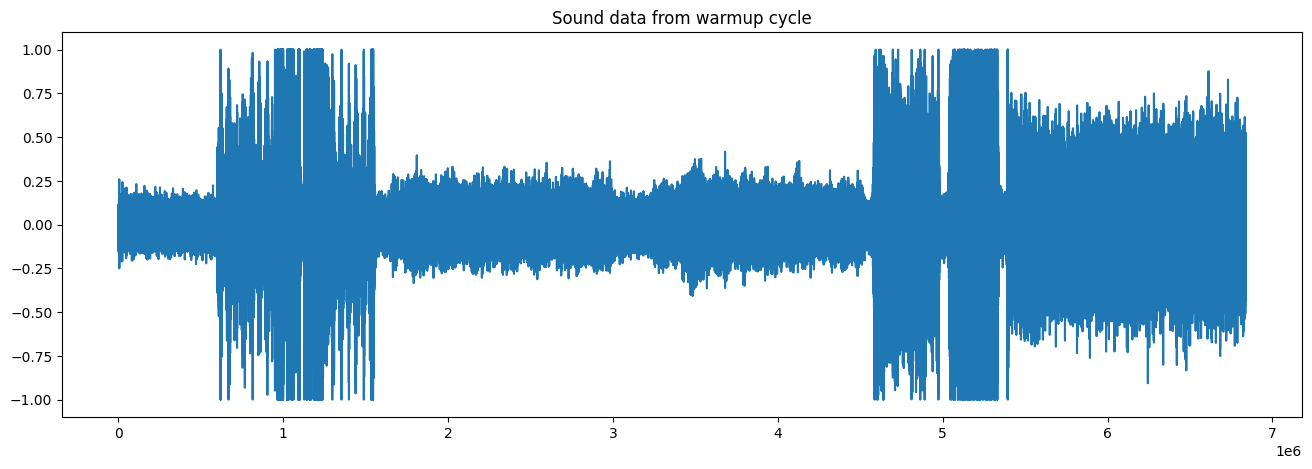

In [ ]:
import matplotlib.pyplot as plt

# Plot sound data
plt.figure(figsize=(16,5))
plt.title("Sound data from warmup cycle")
plt.plot(sound)
plt.show()

## Step 2: Data Indexing

In [ ]:
import numpy as np

# Index data by timestamps [second]
# class 1 [12.46, 32.51]    Tool Change
# class 2 [32.51, 65.57]    Chip Conveyer
# class 3 [65.57, 95.30]    X
# class 4 [95.30, 104.36]   Y
# class 5 [104.36, 112.12]  Z
# class 6 [112.12, :]       Spindle

timestamp=[12.46, 32.51, 65.57, 95.30, 104.36, 112.12]
index=np.multiply(rate,timestamp).astype(np.int64) # indices must be integers
print(index)

[ 598080 1560480 3147359 4574400 5009280 5381760]


In [ ]:
# Index data and split into 6 classes
indexed_data = []
num_class=6
for i in range(num_class):
  if i == num_class-1: #Last segment
    indexed_data.append(sound[index[i]:])
  else:
    indexed_data.append(sound[index[i]:index[i+1]])

for i, c in enumerate(indexed_data):
  print("Class", i+1, c)

Class 1 [ 0.04415894  0.04882812  0.05239868 ... -0.02410889 -0.02539062
 -0.02697754]
Class 2 [-0.02874756 -0.03045654 -0.03216553 ... -0.03585815 -0.03518677
 -0.03457642]
Class 3 [-0.03366089 -0.03225708 -0.03039551 ...  0.07983398  0.07562256
  0.07156372]
Class 4 [0.06835938 0.06542969 0.06298828 ... 0.10250854 0.10235596 0.10235596]
Class 5 [0.10220337 0.10144043 0.1005249  ... 0.07397461 0.07315063 0.07260132]
Class 6 [0.07177734 0.07070923 0.06945801 ... 0.5187988  0.51168823 0.5028076 ]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


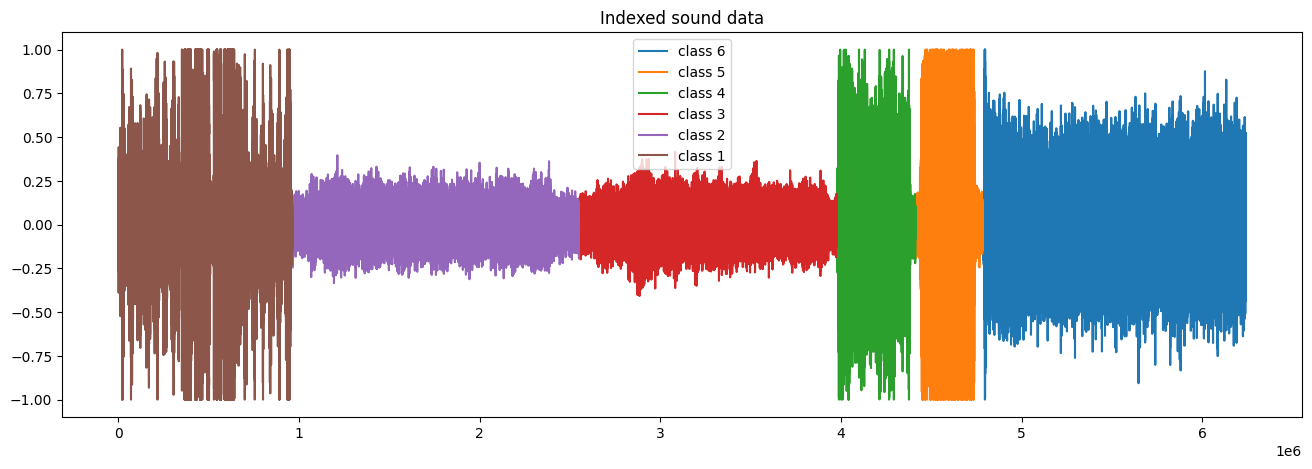

In [ ]:
# Pad the segments to plot
current_index = 0
indexed_pad_data=[]
first = True
for i, rg in enumerate(indexed_data):
  if first:
    first = False
    padded_data = rg
    prev_pad = np.zeros(len(rg))
  else:
    padded_data = np.append(prev_pad, rg)
    current_index += len(rg)
    prev_pad = np.append(prev_pad,np.zeros(len(rg)))

  indexed_pad_data.append(padded_data)

# Check padded data
# for i, pad_c in enumerate(indexed_pad_data):
#   print("class with padding", i+1, ":", pad_c)

# Plot and check ranges
plt.figure(figsize=(16,5))
plt.title("Indexed sound data")
for i in reversed(range(num_class)):
  plt.plot(indexed_pad_data[i], label=f"class {i+1}")
plt.legend()
plt.show()

## Step 3: Data Segmentation

In [ ]:
# Define variables for segmentation
segment_length=int(1*rate) # 1 segment per 1 second
overlap=int(0.8*rate) # segment with 0.8 second overlap

In [ ]:
# Define a function for data segmentation
def segmentation(indexed_data):
  total_length = len(indexed_data)

  # Calculate the number of data points not included in the last segment
  num_total_segments = total_length // (segment_length - overlap) # this variable includes the last segment with fewer values
  last_segment_start = num_total_segments * (segment_length - overlap) # start index of the last segment
  remaining_data = total_length - last_segment_start
  print("Number of data points not included:", remaining_data)

  segments = [] # List to store segments
  start_index = 0 # Start index for segments

  # Loop to create segments
  while start_index + segment_length <= total_length:
      segment = indexed_data[start_index:start_index + segment_length]
      segments.append(segment)
      start_index += segment_length - overlap

  # Check the number of segments
  print("Number of segments:", len(segments))

  # Check results
  # for i, segment in enumerate(segments):
  #     print(f"Segment {i+1}: {segment}")

  # Check all segments have the right length (segment_length)
  # for segment in segments:
  #   print(len(segment))

  return segments

In [ ]:
for i in range(num_class):
  exec(f'print("Class {i+1}")')
  exec(f'class_{i+1}=segmentation(indexed_data[{i}])')

Class 1
Number of data points not included: 2400
Number of segments: 96
Class 2
Number of data points not included: 2879
Number of segments: 161
Class 3
Number of data points not included: 6241
Number of segments: 144
Class 4
Number of data points not included: 2880
Number of segments: 41
Class 5
Number of data points not included: 7680
Number of segments: 34
Class 6
Number of data points not included: 6556
Number of segments: 147


In [ ]:
import os

# Save the segmented data
save_path="/content/drive/MyDrive/Colab Notebooks/SavedFiles/segments"

for i in range(num_class):
  # option 1: save as numpy array
  exec(f"np.save(os.path.join(save_path, 'class{i+1}'), class_{i+1})")
  # option 2: save array into csv file
  # exec(f"np.savetxt(os.path.join(save_path,'class{i+1}.csv'), class_{i+1}, delimiter = ',')")

In [ ]:
import pandas as pd

# Import segmented data
load_path="/content/drive/MyDrive/Colab Notebooks/SavedFiles/segments"

for i in range(num_class):
  # option 1: load numpy array and convert to pandas data frame
  exec(f"class{i+1} = pd.DataFrame(np.load(os.path.join(load_path, 'class{i+1}.npy'))).T")
  # option 2: save array into csv file
  # exec(f"class{i+1} = pd.read_csv(os.path.join(load_path,'class{i+1}.csv'), sep=',', header=None).T")

  exec(f"print('class{i+1}:', class{i+1}.shape)")

class1: (48000, 96)
class2: (48000, 161)
class3: (48000, 144)
class4: (48000, 41)
class5: (48000, 34)
class6: (48000, 147)


## Step 4: Feature extraction

### 4-1. P-value

In [ ]:
# Define number of data for each class and number of features
num_data=[]
for i in range(num_class):
  exec(f"num_data.append(class{i+1}.shape[1])")

num_feature = 10 # 10 Feature types: Max, Min, Mean, RMS, Variance, Skewness, Kurtosis, Crest factor, Shape factor, Impulse factor

print("number of data:", num_data, "\nnumber of feature:", num_feature)

number of data: [96, 161, 144, 41, 34, 147] 
number of feature: 10


4-1-1. Time domain feature extraction (ML 3_1)

In [ ]:
import scipy.stats as sp

def time_feature_extraction(class_data):
  num_data = class_data.shape[1]

  # Create empty(0) arrays for feature dataset (time domain)
  time_feature_data = np.zeros((num_feature, num_data))

  # Define rms function
  def rms(x):
    return np.sqrt(np.mean(x**2))

  # Time domain feature extraction
  for i in range(num_data):
    time_feature_data[0, i] = np.max(class_data.iloc[:,i])
    time_feature_data[1, i] = np.min(class_data.iloc[:,i])
    time_feature_data[2, i] = np.mean(class_data.iloc[:,i])
    time_feature_data[3, i] = rms(class_data.iloc[:,i])
    time_feature_data[4, i] = np.var(class_data.iloc[:,i])
    time_feature_data[5, i] = sp.skew(class_data.iloc[:,i])
    time_feature_data[6, i] = sp.kurtosis(class_data.iloc[:,i])
    time_feature_data[7, i] = np.max(class_data.iloc[:,i])/rms(class_data.iloc[:,i])
    time_feature_data[8, i] = rms(class_data.iloc[:,i])/np.mean(np.abs(class_data.iloc[:,i]))
    time_feature_data[9, i] = np.max(class_data.iloc[:,i])/np.mean(np.abs(class_data.iloc[:,i]))

  return time_feature_data

In [ ]:
for i in range(num_class):
  exec(f"time_feature_class{i+1} = time_feature_extraction(class{i+1})")

In [ ]:
# Combine feature arrays
concat_data = [time_feature_class1, time_feature_class2, time_feature_class3, time_feature_class4, time_feature_class5, time_feature_class6]
time_feature = np.concatenate(concat_data , axis=1)
time_feature.shape

(10, 623)

4-1-2. Frequency domain feature extraction (ML 3_1)

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 101.4 MB/s eta 0:00:00


In [ ]:
import pywt

# Wavelet options
MotherWavelet = pywt.Wavelet('haar') # Mother wavelet
level = 8 # Wavelet decomposition level

In [ ]:
def freq_feature_extraction(class_data):
  num_data = class_data.shape[1]

  # Create empty(0) arrays for feature dataset (frequency domain)
  freq_feature_data = np.zeros(shape=(num_feature*level , num_data))

  # Define rms function
  def rms(x):
    return np.sqrt(np.mean(x**2))

  for i in range(num_data):
    # Walvelet decomposition
    coeff = pywt.wavedec(class_data.iloc[:,i], MotherWavelet, level=level, axis=0)

    # Frequency domain feature extraction
    for k in np.arange(level):
      coefficient = coeff[level-k]

      freq_feature_data[k*num_feature+0, i] = np.max(coefficient)
      freq_feature_data[k*num_feature+1, i] = np.min(coefficient)
      freq_feature_data[k*num_feature+2, i] = np.mean(coefficient)
      freq_feature_data[k*num_feature+3, i] = rms(coefficient)
      freq_feature_data[k*num_feature+4, i] = np.var(coefficient)
      freq_feature_data[k*num_feature+5, i] = sp.skew(coefficient)
      freq_feature_data[k*num_feature+6, i] = sp.kurtosis(coefficient)
      freq_feature_data[k*num_feature+7, i] = np.max(coefficient)/rms(coefficient)
      freq_feature_data[k*num_feature+8, i] = rms(coefficient)/np.mean(np.abs(coefficient))
      freq_feature_data[k*num_feature+9, i] = np.max(coefficient)/np.mean(np.abs(coefficient))

  return freq_feature_data

In [ ]:
for i in range(num_class):
  exec(f"freq_feature_class{i+1} = freq_feature_extraction(class{i+1})")

In [ ]:
# Combine feature arrays
concat_data = [freq_feature_class1, freq_feature_class2, freq_feature_class3, freq_feature_class4, freq_feature_class5, freq_feature_class6]
freq_feature = np.concatenate(concat_data , axis=1)
freq_feature.shape

(80, 623)

In [ ]:
# Final feature dataset
# 10 Time domain features + 80 Frequency domain features = 90 features
features = np.concatenate([time_feature,freq_feature] , axis=0)

print("Shape of the total features:", features.shape)

# Convert array into data frame format
feature_df = pd.DataFrame(features)

Shape of the total features: (90, 623)


In [ ]:
feature_save_path = "/content/drive/MyDrive/Colab Notebooks/SavedFiles/feature_dataset.csv"
feature_df.to_csv(feature_save_path, sep=',', header=None , index=None)

4-1-3. P-value calculation (ANOVA) (ML 3_2)
- Unlike using the t-test to select advantageous features for binary classification, we typically use the ANOVA (Analysis of Variance) test for feature selection in **multi-class classification** problems.
- For the Python code, it is very similar to what we did with the 't-test', and ultimately, the result we want to know is the same: the P-value.
- To perform the ANOVA test, you just need to replace the t-test function (sp.ttest_ind) with the ANOVA execution function (sp.f_oneway). (Of course, the input parameters should include the feature datasets for all classes.)
- If you want to understand more about the ANOVA test, refer to the video below.

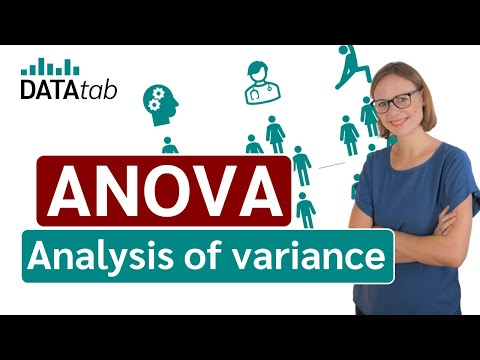

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('0NwA9xxxtHw')

In [ ]:
feature_load_path = "/content/drive/MyDrive/Colab Notebooks/SavedFiles/feature_dataset.csv"

feature_data = pd.read_csv(feature_load_path, header=None)

In [ ]:
num_data=[]
for i in range(num_class):
  exec(f"num_data.append(class{i+1}.shape[1])")

# Calculate the index
d_index = [sum(num_data[:i+1]) for i in range(len(num_data))]

# Index feature data
first = True
for i in range(num_class):
  if first:
    exec(f"c{i+1}_feature = feature_data.iloc[:,:d_index[{i}]]")
    first = False
  else:
    exec(f"c{i+1}_feature = feature_data.iloc[:,d_index[{i-1}]:d_index[{i}]]")
  exec(f"print(c{i+1}_feature.shape)")

(90, 96)
(90, 161)
(90, 144)
(90, 41)
(90, 34)
(90, 147)


In [ ]:
num_feature = feature_data.shape[0] # Number of feature: 90

# Create empty(0) arrays for p-value dataset
p_value = np.zeros((num_feature, 2))

# P-value by ANOVA
for i in np.arange(num_feature):
  anova = np.array(sp.f_oneway(c1_feature.iloc[i,:], c2_feature.iloc[i,:], c3_feature.iloc[i,:], c4_feature.iloc[i,:], c5_feature.iloc[i,:], c6_feature.iloc[i,:]))
  p_value[i,0] = int(i) # Index of feature (0~89)
  p_value[i,1] = anova[1] # p-value

p_value = pd.DataFrame(p_value, columns=['No.', 'P-value'])
p_value

,No.,P-value
0,0.0,0.000000e+00
1,1.0,0.000000e+00
2,2.0,2.711030e-12
3,3.0,5.884906e-177
4,4.0,3.140021e-98
...,...,...
85,85.0,6.797574e-02
86,86.0,2.214137e-90
87,87.0,8.084487e-34
88,88.0,5.093821e-102


In [ ]:
# Sort by P-value in ascending order
p_value_rank = p_value.sort_values(['P-value'], ascending=True)
p_value_rank

,No.,P-value
0,0.0,0.000000e+00
1,1.0,0.000000e+00
50,50.0,1.223884e-275
51,51.0,8.483250e-264
61,61.0,4.118030e-262
...,...,...
85,85.0,6.797574e-02
12,12.0,2.553379e-01
52,52.0,4.414499e-01
22,22.0,9.363459e-01


In [ ]:
# Save t-Test result (p-value)
p_path = '/content/drive/MyDrive/Colab Notebooks/SavedFiles/P_value.csv'
p_rank_path = '/content/drive/MyDrive/Colab Notebooks/SavedFiles/P_value_Rank.csv'

p_value.to_csv(p_path, sep=',', header=None, index=None)
p_value_rank.to_csv(p_rank_path, sep=',', header=None, index=None)

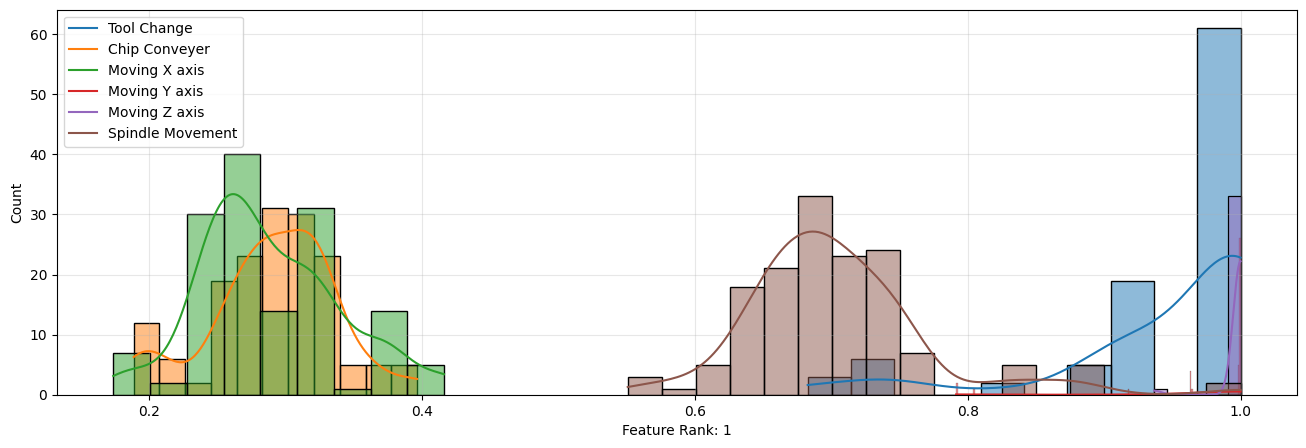

In [ ]:
import seaborn as sb

# Confirm PDF(Probabilistic Density Function) graphs
# P-value rank (0 ~ 89)
FeatureRank = 0

# PDF Chart
class_label=['Tool Change', 'Chip Conveyer', 'Moving X axis', 'Moving Y axis', 'Moving Z axis', 'Spindle Movement']
plt.figure(figsize=(16,5))

for i in range(num_class):
  exec(f"sb.histplot(c{i+1}_feature.iloc[int(p_value_rank.iloc[FeatureRank,0]),:], kde=True)")

plt.legend(class_label, loc='best', fontsize=10)
plt.xlabel(f'Feature Rank: {FeatureRank+1}')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Select top features having low P-values
rank = 30  # Select number of rank

def feature_selection(class_feature):
  num_data=class_feature.shape[1]
  selected_feature = np.zeros((rank,num_data))
  for i in range(rank):
    index = int(p_value_rank.iloc[i,0])
    selected_feature[i,:] = class_feature.iloc[index,:].values
  return selected_feature

for i in range(num_class):
  exec(f"c{i+1}=feature_selection(c{i+1}_feature)")

FeatureSelected = pd.DataFrame(np.concatenate([c1, c2, c3, c4, c5, c6] , axis=1))

print("Selected Feature Data Size :", FeatureSelected.shape)

Selected Feature Data Size : (30, 623)


In [ ]:
# Save selected feature data as csv file

sel_feature_path = '/content/drive/MyDrive/Colab Notebooks/SavedFiles/FeatureSelected.csv'
FeatureSelected.to_csv(sel_feature_path, sep=',', header=None, index=None)

### 4-2. STFT (Short-Time Fourier Transform) (ML 6_1)

In [ ]:
# Import segmented data
load_path="/content/drive/MyDrive/Colab Notebooks/SavedFiles/segments"

for i in range(num_class):
  # option 1: load numpy array and convert to pandas data frame
  exec(f"class{i+1} = pd.DataFrame(np.load(os.path.join(load_path, 'class{i+1}.npy')))")
  # option 2: save array into csv file
  # exec(f"class{i+1} = pd.read_csv(os.path.join(load_path,'class{i+1}.csv'), sep=',', header=None)")
  exec(f"print('class{i+1}:', class{i+1}.shape)")

class1: (96, 48000)
class2: (161, 48000)
class3: (144, 48000)
class4: (41, 48000)
class5: (34, 48000)
class6: (147, 48000)


In [ ]:
data_list = [class1, class2, class3, class4, class5, class6]
SoundData = np.concatenate(data_list , axis=0)
print(SoundData.shape)

(623, 48000)


In [ ]:
from scipy import signal

Fs = rate  # sampling frequency
nperseg = 78 # number of samples per segment
noverlap = 10 # number of samples for overlap

f,t,soundSTFT = signal.spectrogram(SoundData, Fs, nperseg=nperseg, noverlap=noverlap)
print(soundSTFT.shape)

(623, 40, 705)


In [ ]:
num_data=[]
for i in range(num_class):
  exec(f"num_data.append(class{i+1}.shape[0])")

# Calculate the index
d_index = [sum(num_data[:i+1]) for i in range(len(num_data))]

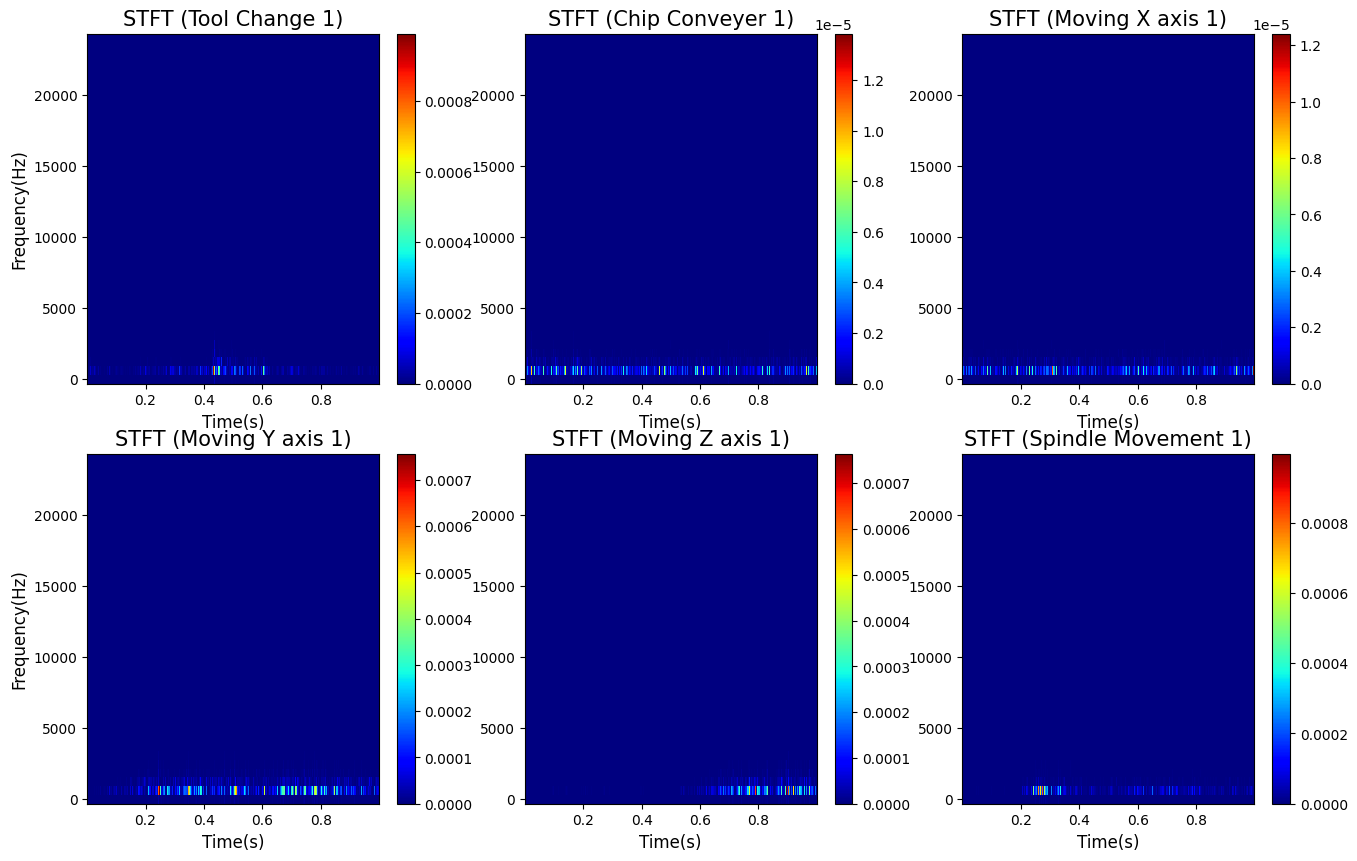

In [ ]:
class_label=['Tool Change', 'Chip Conveyer', 'Moving X axis', 'Moving Y axis', 'Moving Z axis', 'Spindle Movement']

idx = 1 # Select index

first=True
plt.figure(figsize=(16,10))
for i in range(len(d_index)):
    plt.subplot(2, 3, i+1)
    if first:
      plt.pcolormesh(t, f, soundSTFT[idx-1], cmap='jet')
      first=False
    else:
      plt.pcolormesh(t, f, soundSTFT[idx + d_index[i-1]-1], cmap='jet')
    plt.title(f"STFT ({class_label[i]} {idx})", fontsize=15)
    plt.xlabel('Time(s)', fontsize=12)
    if i in [0, 3]:
        plt.ylabel('Frequency(Hz)', fontsize=12)
    plt.colorbar()

plt.show()

In [ ]:
# Save STFT as a NumPy file
# Save the segmented data
stft_save_path="/content/drive/MyDrive/Colab Notebooks/SavedFiles"

np.save(os.path.join(stft_save_path, "SoundSTFT.npy"), soundSTFT)

In [ ]:
import scipy.stats       as sp
import tensorflow        as tf
from tensorflow                 import keras
from keras.models    import Model
from sklearn.model_selection    import train_test_split

In [ ]:
# Define each condition's name and number of samples
cond = ['Tool Change', 'Chip Conveyer', 'Moving X axis', 'Moving Y axis', 'Moving Z axis', 'Spindle Movement']

NoOfData = pd.DataFrame([96, 161, 144, 41, 34, 147])
NoOfData

,0
0,96
1,161
2,144
3,41
4,34
5,147


In [ ]:
# Load STFT dataset that you saved in ML8
DataSet = np.load('/content/drive/MyDrive/Colab Notebooks/SavedFiles/SoundSTFT.npy')[:,:,:-1]
DataSet.shape

(623, 40, 704)

In [ ]:
# Check the width and height of each STFT spectrogram
width, height = DataSet.shape[1], DataSet.shape[2]
width, height

(40, 704)

In [ ]:
# Scale the Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from joblib import dump, load

DataSet_2d = DataSet.reshape(DataSet.shape[0],-1)
print(DataSet_2d.shape)

scaler_std = StandardScaler()
scaler_mMx = MinMaxScaler()
DataSet_2d_scaled_1 = scaler_std.fit_transform(DataSet_2d)
DataSet_2d_scaled_2 = scaler_mMx.fit_transform(DataSet_2d_scaled_1)

DataSet_scaled = DataSet_2d_scaled_2.reshape(DataSet.shape[0], DataSet.shape[1], DataSet.shape[2])
print(DataSet_scaled.shape)

(623, 28160)
(623, 40, 704)


In [ ]:
# Assuming `stft_image` is (40, 704), -> mobilenet_v2 requires 224x224x3 image size
def preprocess_stft(stft_image, target_shape):
    image = tf.image.resize(stft_image, target_shape)
    image = tf.image.grayscale_to_rgb(tf.expand_dims(image, -1))  # shape: (224, 224, 3)
    return image

In [ ]:
shape = [224, 224]
DataSet_rsp = preprocess_stft(DataSet_scaled.reshape(width, height, -1), shape)
DataSet_rsp = tf.reshape(DataSet_rsp, (-1, shape[0], shape[1], 3)).numpy()

In [ ]:
print(DataSet_rsp.shape[1:])

(224, 224, 3)


In [ ]:
# Prepare train/test dataset for Conv_AE modeling
Train_Test_Ratio = 0.2

DataSet_1 = DataSet_rsp[sum(NoOfData.iloc[:0,0]):sum(NoOfData.iloc[:0,0])+NoOfData.iloc[0,0]]
DataSet_2 = DataSet_rsp[sum(NoOfData.iloc[:1,0]):sum(NoOfData.iloc[:1,0])+NoOfData.iloc[1,0]]
DataSet_3 = DataSet_rsp[sum(NoOfData.iloc[:2,0]):sum(NoOfData.iloc[:2,0])+NoOfData.iloc[2,0]]
DataSet_4 = DataSet_rsp[sum(NoOfData.iloc[:3,0]):sum(NoOfData.iloc[:3,0])+NoOfData.iloc[3,0]]
DataSet_5 = DataSet_rsp[sum(NoOfData.iloc[:4,0]):sum(NoOfData.iloc[:4,0])+NoOfData.iloc[4,0]]
DataSet_6 = DataSet_rsp[sum(NoOfData.iloc[:5,0]):sum(NoOfData.iloc[:5,0])+NoOfData.iloc[5,0]]

TrainD1, TestD1, = train_test_split(DataSet_1, test_size=Train_Test_Ratio, random_state = 777)
TrainD2, TestD2, = train_test_split(DataSet_2, test_size=Train_Test_Ratio, random_state = 777)
TrainD3, TestD3, = train_test_split(DataSet_3, test_size=Train_Test_Ratio, random_state = 777)
TrainD4, TestD4, = train_test_split(DataSet_4, test_size=Train_Test_Ratio, random_state = 777)
TrainD5, TestD5, = train_test_split(DataSet_5, test_size=Train_Test_Ratio, random_state = 777)
TrainD6, TestD6, = train_test_split(DataSet_6, test_size=Train_Test_Ratio, random_state = 777)

TrainData  = np.concatenate([TrainD1, TrainD2, TrainD3, TrainD4, TrainD5, TrainD6], axis=0)
TestData   = np.concatenate([TestD1 , TestD2 , TestD3 , TestD4, TestD5, TestD6 ], axis=0)

TrainLabel = # Generate a label corresponding to each training data
TestLabel =  # Generate a label corresponding to each test data

TrainData.shape , TestData.shape

((495, 224, 224, 3), (128, 224, 224, 3))

In [ ]:
IMG_SHAPE = DataSet_rsp.shape[1:]

In [ ]:
# Create a custom TensorFlow Datasets
# Hint : You could use 'tf.data.Dataset.from_tensor_slices' to combine data and labels and generate your own dataset

In [ ]:
# Build your own model using any pre-trained NN
# Hint1 : There should be a total of 6 classes (i.e., multi-class classification)
# Hint2 : Use 'categorical_crossentropy' as a loss function

In [ ]:
# Train your own model and see how it works